# Hangman Word Guessing Game

## Key Points of Core Strategies:
1. Heuristic Greedy Algorithm
2. Inference of Population Using Sample Frequencies
3. N-gram Strategy
4. Optimization of Algorithm Time Complexity

# <u>**Finetuned Optimization:**</u>
1. Optimization and Combination of N in N-gram
2. <u>Vague Positional</u> Selection Based on Length
3. Vowel Letters Selection Based on Length
3. Weighting Frequency Based on the Number of Letters in Fragments
4. Prioritization of Beginning and Ending Fragments in Inferring Most Likely Letters
5. Data Augmentation in Training Set


## Detailed Analyze

### 1. Basic Selection Idea
- **Heuristic Greedy Algorithm:** When the dictionary scope is limited, the guessed letter under the current conditions (blanked_word, guessed_wrong_letter) should maximize the information gain / potential life loss ratio to narrow down the possible word range in the dictionary.

s.t. $\left\{\begin{array}{l}\text { blank word }="--p-e^{\prime \prime} \\ \text { guessed letter }=" l k "\end{array}\right.$
opt. $\max \left\{\frac{\text { information gain (guess) }}{E(\text { trial loss) }}\right\}$


- Unfortunately, the dictionary scope is nearly infinite. Therefore, in the heuristic approach, the locally greedy strategy of guessing the most probable letter at each step predominates.

### 2. Training Data Constraints
- **Inapplicability of NLP Model Algorithms:** If many words are allowed for training, NLP models such as transformer-based BERD can infer semantics based on context and naturally apply to inferring remaining words based on preceding and succeeding letters.
- However, this problem only permits training on **250000** words. Hence, constructing an NLP network is not feasible. Utilizing pre-trained models with modified corresponding output heads is also impractical, so I resorted to inferring the most likely letters based on the **statistical distribution patterns** among English words.

### 3. Sample Frequency Inference
- **Using Samples to Infer Population:** I use samples to infer the population, meaning that given word_blank = "_ _ a _ _" and guessed_letter = "lk" as the wrongly guessed letter, the probability of the most likely letter is equal to the highest frequency letter in words that meet this condition in the sample.
- However, the existing sample size of 250000 letters is insufficient to infer the population. (Baselines' success rate is only 18%). Hence, based on the idea of data augmentation, **word fragments** may assist in inferring the population. Many long words are composed of shorter morphemes through derivation (adding prefixes and suffixes) and compounding. 
- Therefore, dividing long words into [different fragments and statistically analyzing the frequency of letters]() that meet the restricted conditions in this population can identify the most likely appearing letters.

### 4. N-gram Strategy
- The above method effectively utilizes information from word fragments **with lengths greater than the current word_blank length**. 
- However, for longer word_blanks, information from words with lengths less than the current word_blank cannot be utilized. Therefore, to effectively use information from words, one can infer, based on the length of the current word_blank, the most probable letters that meet the conditions within the partial length of the current word_blank. This corresponds to the N-gram method in the NLP field.

$$s.t.  \left\{\begin{array}{l}\text { blank word }="--p-e^{\prime \prime} \\ \text { guessed letter }=" l k "\end{array}\right.$$



$$
p\left(w_1, w_2, \ldots w_n\right)=p\left(w_2, w_3, \ldots w_n\right) \times p\left(w_1 \mid w_2, w_3, \ldots w_n\right)
$$



Where $w_1= ($ ' $a$ ' appear in the blank); $w_2, \ldots w_n$ refers to the s.t. (e.g. $w_2=$ the third letter is $p$ )


$$
\begin{aligned}
&\begin{aligned}
\therefore P\left(w_1, w_2, \cdots, w_n\right) & =\prod_{i=1}^m P\left(w_i \mid w_{i-1},  w_{i-2}, \ldots w_{i-n}\right) \hat{=} \sum_{i=1}^m \operatorname{freq}\left(w_i \mid w_{i-1}, w_{i-2},  \ldots w_{i-n})\right. 
\end{aligned}\\
&\therefore \text { guess }=\operatorname{argmax}\left\{\sum_{i=1}^m \operatorname{freq}\left(w_i \mid w_{i-1}, w_{i-2}, \ldots w_{i-n}\right)\right\}.
\end{aligned}
$$

### 5. Optimization of Algorithm Time Complexity
- **Constructing Frequency Tables:** Based on the aforementioned basic strategy, it is necessary to search for all words and word fragments that meet the current gram requirements in 250000 samples and find the most probable letters. As each guess requires searching for statistical frequencies of countless word fragments of different lengths of grams, the complexity is extremely high. Hence, it is advisable to pre-make N-gram word fragment frequency tables for direct querying in each guess.

### 6. Cases of Search failed
- For cases where the word cannot be found in the training set, we can use the length information to guess the most frequency letter, e.g., word_blank = "_ _ a _ _," providing length information, searching for the most likely appearing letters in all words matching this length serves as the guess.

##### The statistical model trained through the above process achieves an inference accuracy of 50.77%.

##### Hence Some furthermore finetuned should be made to achieve high scores


### 7.<u>Furthermore Fine-grained Optimization</u>
- #### 7.1. **Optimization of N-gram's N value:** Choose and combine different N values according to the word's length for inference.
    - After testing, 
    - For words with lengths greater than 7 and less than 10, 5-gram fragments exhibit the highest inference accuracy
    - For words with lengths less than 6, 3-gram fragments demonstrate the highest inference accuracy. 
    - For words with lengths greater than 10, 8-gram fragments exhibit the highest inference accuracy. 
    - Given the limited number of words, words with lengths exceeding 19 do not satisfy the condition of the law of large numbers **(See appendix)**. larger N in N-gram represents information closer to the current word, thus, adopting a combined N-gram strategy:
        - For lengths greater than 8, use 8-gram for inference.
        - For words with lengths between 5 and 8, combine 6-gram and 5-gram for inference, considering that 6-gram may contain richer information, and a 6-gram encompasses two 5-grams. Therefore, the frequency value of 5-gram is multiplied by 0.4 and added to the frequency value of 6-gram.
        - For lengths less than 5, use 3-gram for inference.
        - For lengths less than 3, the probability of correct guessing is low.
        
##### Enhance scores to 55.77%

- #### 7.2. **Positional Information:** 
- N-gram provides a fragment of word_blank = "_ _ a _ _" with a length of N, losing the positional information of N-gram in this word.
- For instance, "__e" is more likely to be "pre" when used as a prefix, but "ble" when used as a suffix. Therefore, the position of N-gram in the word affects the most probable letters during inference. However, if the division of N-gram's position in a word is too detailed, it will reduce the effective sample quantity of this (N-gram, position) combination in 250000 words, reducing the generalization of statistical inference models. Thus, the following vague-position improvements are made:
    - For 5-gram, record whether the current 5-gram appears in the beginning or end of the word. 5-grams appearing in the beginning are recorded as "__e_t&0", and those appearing at the end are recorded as "__e_t&1".
    - For 3-gram, record which third of the word the current 3-gram belongs to, denoted as "\_e\_&0", "\_e\_&1", and "\_e\_&2".

##### Enhance scores to 58.06%

- #### 7.3. **Vowel Ratio:** Filter results based on vowel ratio.
    - After statistics, it's found that when the length is less than 7, a vowel letter ratio exceeding 0.67 is a rare event. When the length is greater than 7, a vowel letter ratio exceeding 0.54 is a rare event. Therefore, it's deemed unlikely that rare events occur when the vowel letter ratio exceeds 0.67 (len <= 7) / 0.54 (len > 7). Thus, filter out all vowel letters after this threshold.
    - See appendix for specific details.
    
##### Enhance scores to 58.66%

- #### 7.4. **Information Degree Weighting:** 
    - Different N-grams provide different information degrees. For word_blank = "b e _ _ t _ _ _ l", the information conveyed by the 5-gram "b e _ _ t" should be significantly greater than "_ _ t _ _", so the optimization strategy weights frequencies according to the number of letters contained in N-grams.

##### Enhance scores to 59.46%

- #### 7.5. **Priority of Word Beginning and Ending:** Assign higher weights to N-grams at the beginning and end of words.
    - N-gram fragments at the beginning and end of words generally possess stronger inference capabilities since word roots and affixes are important in word formation. For instance, in "beautiful," the middle "eaut" often lacks a combined meaning. Thus, selecting N-gram fragments at the beginning and end of words yields the most probable letters, so the optimization strategy assigns higher weights to them.
    
##### Enhance scores to 60.62%

- #### 7.6. **Data Augmentation:** Add common word roots and affixes to the training set.
    - By adding common word roots and affixes to the training set, the statistical model learns these patterns and incorporates some common short word expressions.

##### Enhance scores to 61.62%

##### After the above optimizations, the testing accuracy on the test set with lengths greater than or equal to 7 has been improved to 89.6%. However, the accuracy on shorter words with lengths less than or equal to 6 is only 49.2%, and for words with lengths less than 3, correct guessing becomes significantly challenging, thus the addition of some common short word expressions is suggested.

### Some Failed Attempts
- **Information from Wrongly Guessed Letters:** Attempted to utilize the information of wrongly guessed letters to statistically infer frequencies, but it was unsuccessful.
- The success rate of the Hangman game modified with the large language model "gpt3" is approximately 67%, indicating that there exists a certain upper limit to the success rate of the Hangman game (especially when shorter words constitute a higher proportion).


## I have also tried NLP transformer model to solve this problems


- I employed a standard NLP context Mask Prediction model. The input comprises words with masked elements, where the decoder side receives unmasked words. Eventually, the output, after being passed through softmax and max-pooling layers, yields the most probable letter for the predicted word, serving as the guess.

- The network architecture leverages a conventional nn.transformer setup, incorporating Embedding + positionalEncoding, Encoder, Decoder, and multi-head attention mechanisms.

- but it did not beat my statistical models

## Appendix, Some Statistical Features：

In [1]:
from itertools import combinations
from collections import defaultdict
from collections import Counter
full_dictionary_location = "words_250000_train.txt"

text_file = open(full_dictionary_location,"r")
full_dictionary = text_file.read().splitlines()
text_file.close()

vowels = ['a', 'e', 'i', 'o', 'u']
# for ratio of vowels to length of word
def vowel_count(clean_word):
    count = 0
    for i in clean_word:
        if i in vowels:
            count += 1.0
    return count/len(clean_word)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dd = defaultdict(list)
for word in full_dictionary:
    dd[len(word)].append(word)
    
ttm = defaultdict(Counter)
for i,j in dd.items():
    for word in j:
        ttm[i][vowel_count(word)*i]+=1

##  *length statistics*

In [8]:
for i,x in enumerate(dd.values()):
    print(i,'-', len(x))



0 - 2201
1 - 19541
2 - 5287
3 - 11274
4 - 30452
5 - 25948
6 - 26953
7 - 30906
8 - 22786
9 - 18178
10 - 12956
11 - 5211
12 - 8710
13 - 225
14 - 1775
15 - 3143
16 - 264
17 - 98
18 - 859
19 - 441
20 - 3
21 - 44
22 - 17
23 - 14
24 - 2
25 - 9
26 - 1
27 - 2


## *Vowel Ratio in different length:*

3 idx=


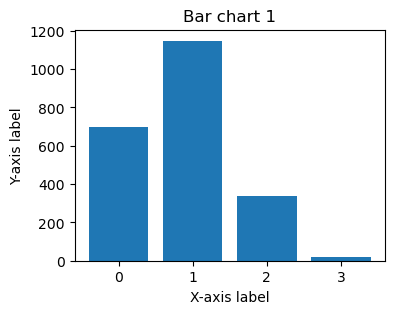

6 idx=


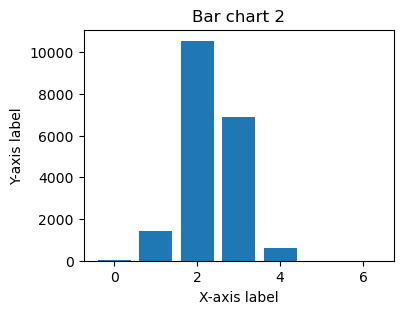

4 idx=


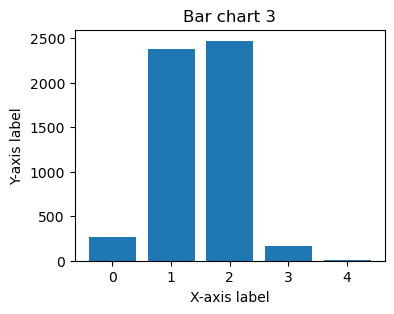

5 idx=


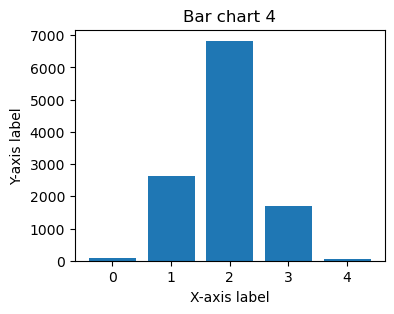

8 idx=


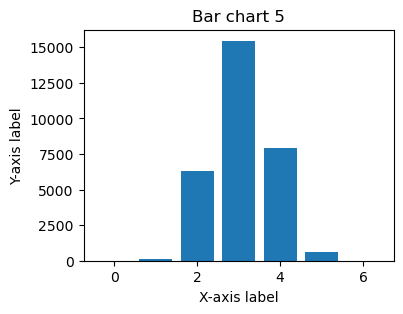

7 idx=


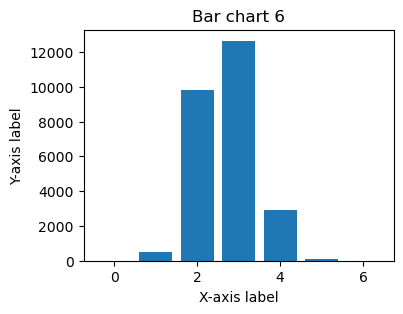

10 idx=


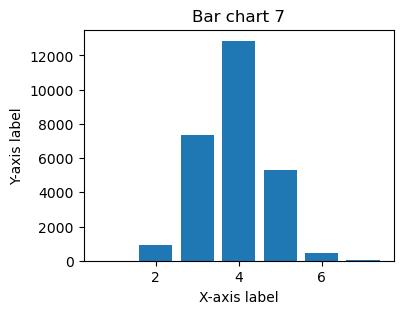

9 idx=


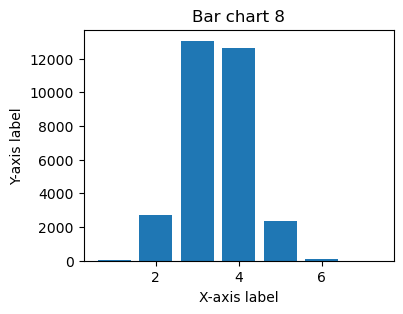

11 idx=


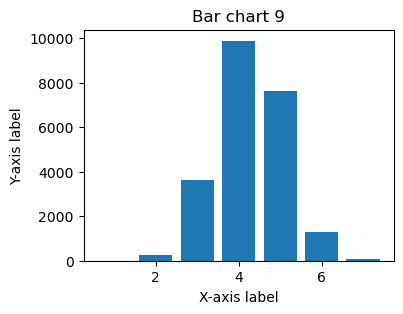

12 idx=


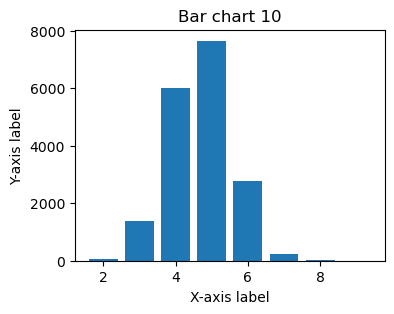

13 idx=


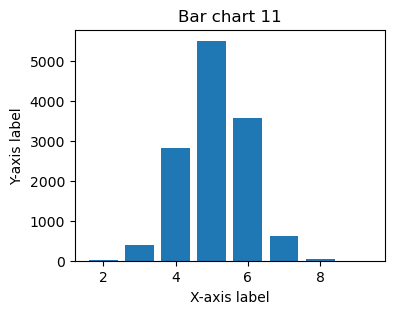

15 idx=


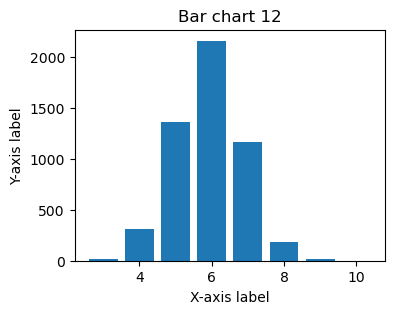

14 idx=


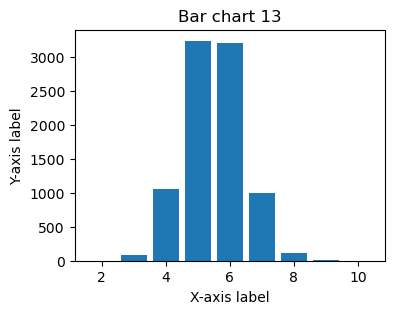

20 idx=


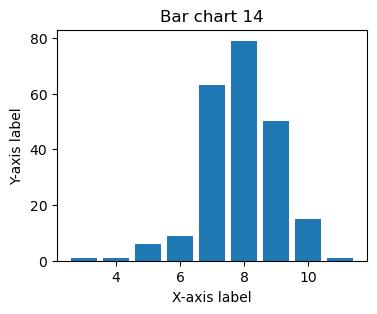

17 idx=


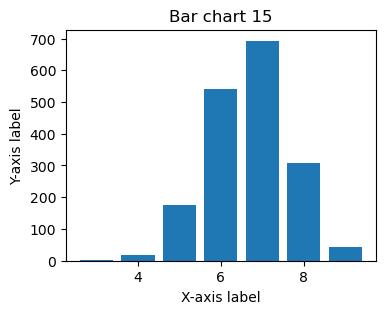

16 idx=


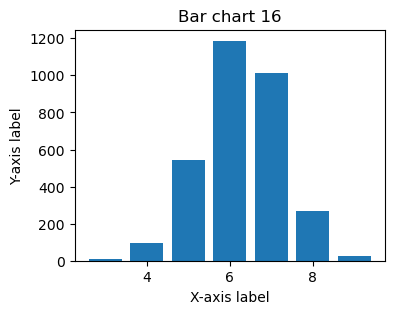

2 idx=


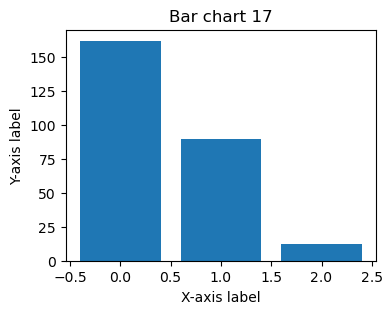

21 idx=


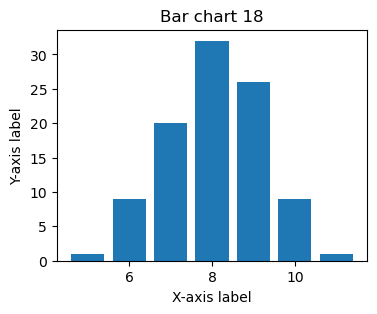

18 idx=


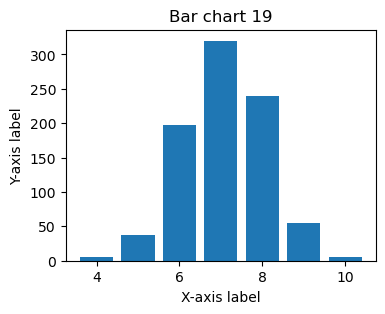

19 idx=


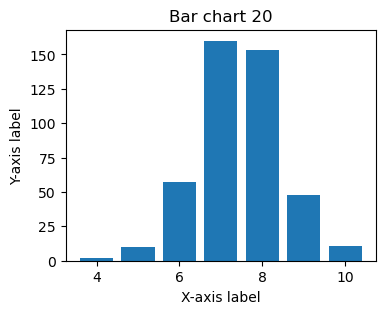

25 idx=


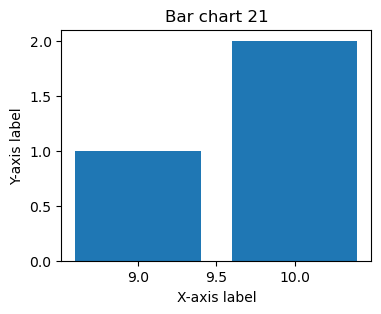

22 idx=


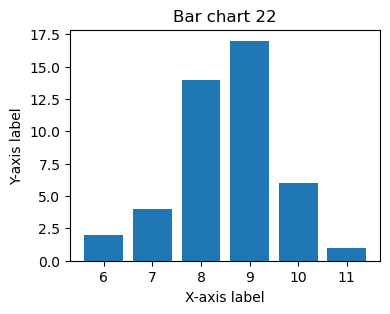

1 idx=


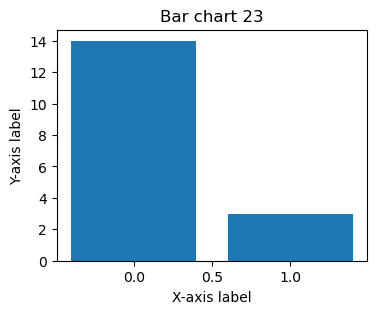

23 idx=


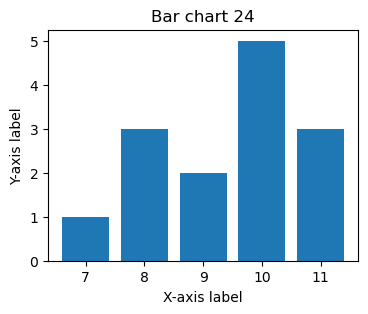

29 idx=


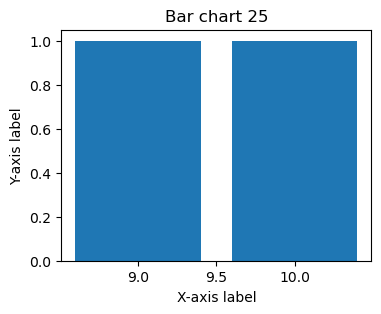

24 idx=


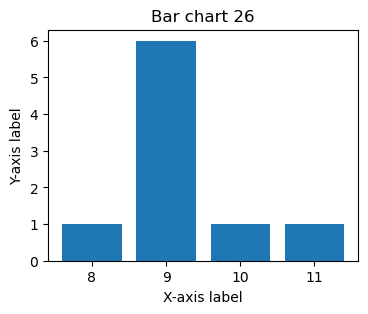

28 idx=


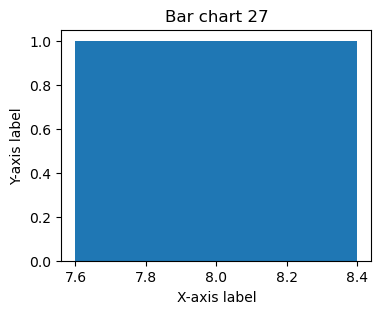

27 idx=


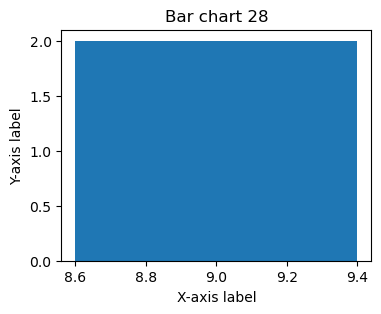

In [11]:
import matplotlib.pyplot as plt

for i, (idx, x) in enumerate(ttm.items()):
    print(idx,'idx=')
    plt.figure(figsize=(4,3))
    plt.bar(x.keys(), x.values())
    plt.title(f'Bar chart {i+1}')
    plt.xlabel('X-axis label')
    plt.ylabel('Y-axis label')
    plt.show()

